## SMS Spam Classification

In [84]:
# importing libraries
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB, GaussianNB, MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score
import matplotlib.pyplot as plt
from nltk.stem.porter import PorterStemmer
import string
from wordcloud import WordCloud
from collections import Counter
import nltk
nltk.download('punkt')
from nltk.corpus import stopwords

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ATUL\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
df = pd.read_csv("spam.csv", encoding='latin-1')

In [3]:
df.sample(5)

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
2495,spam,WINNER! As a valued network customer you hvae ...,NaN,NaN,NaN
2289,spam,Had your mobile 11mths ? Update for FREE to Or...,NaN,NaN,NaN
1597,spam,URGENT! Your Mobile number has been awarded wi...,NaN,NaN,NaN
5364,spam,Call 09095350301 and send our girls into eroti...,NaN,NaN,NaN
1584,ham,"Sorry, I'll call later",NaN,NaN,NaN


In [4]:
df.shape

(5572, 5)

## Data Cleaning

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


Observation : last three columns are not having much values, so they can be dropped.

In [6]:
df.drop(columns=['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], inplace=True)
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [7]:
# renaming the columns :
df.rename(columns={'v1': 'target', 'v2':'text'}, inplace=True)
df.head(5)

,target,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [8]:
# encoding the target columns
le = LabelEncoder()
df['target'] = le.fit_transform(df['target'])
df.head()

,target,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


Observation : LabelEncoder has encoded spam as 1 and ham as 0 

In [9]:
# checking missing values
df.isnull().sum()

target    0
text      0
dtype: int64

In [10]:
# checking duplicate values
df.duplicated().sum()

403

Observation : there are 403 duplicate rows in the dataset, they have to be removed

In [11]:
# removing duplicates 
df = df.drop_duplicates(keep='first')
df.shape

(5169, 2)

## EDA

In [12]:
# check for the balanced dataset
df['target'].value_counts()

0    4516
1     653
Name: target, dtype: int64

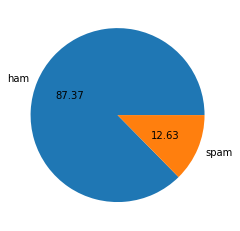

In [13]:
plt.pie(df['target'].value_counts(), labels=['ham', 'spam'], autopct='%.2f')
plt.show()

##### Observation : the dataset is imbalanced.

In [14]:
# creating a column showing number of characters in sms
df['num_chars'] = df['text'].apply(len)

# creating a column showing number of words in sms
df['num_words'] = df['text'].apply(lambda x: len(nltk.word_tokenize(x)))

# creating a column showing number of sentences in sms
df['num_sents'] = df['text'].apply(lambda x:len(nltk.sent_tokenize(x)))

 

In [15]:
df.head()

,target,text,num_chars,num_words,num_sents
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2
1,0,Ok lar... Joking wif u oni...,29,8,2
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2
3,0,U dun say so early hor... U c already then say...,49,13,1
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1


In [16]:
df[df['target']==0][['num_chars', 'num_words', 'num_sents']].describe()

,num_chars,num_words,num_sents
count,4516.000000,4516.000000,4516.000000
mean,70.459256,17.123339,1.815545
std,56.358207,13.491315,1.364098
min,2.000000,1.000000,1.000000
25%,34.000000,8.000000,1.000000
50%,52.000000,13.000000,1.000000
75%,90.000000,22.000000,2.000000
max,910.000000,220.000000,38.000000


In [17]:
df[df['target']==1][['num_chars', 'num_words', 'num_sents']].describe()

,num_chars,num_words,num_sents
count,653.000000,653.000000,653.000000
mean,137.891271,27.667688,2.969372
std,30.137753,7.008418,1.488910
min,13.000000,2.000000,1.000000
25%,132.000000,25.000000,2.000000
50%,149.000000,29.000000,3.000000
75%,157.000000,32.000000,4.000000
max,224.000000,46.000000,9.000000


Observation : from the above values it is clear that spam messages have more characters, words and sentences.

<AxesSubplot:xlabel='num_chars', ylabel='Count'>

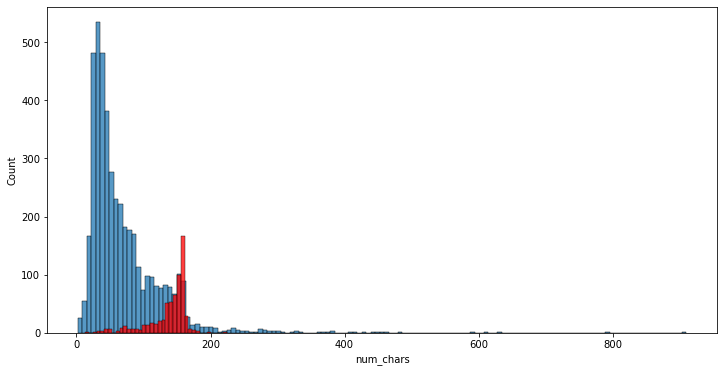

In [18]:
plt.figure(figsize=(12,6))
sns.histplot(df[df['target']==0]['num_chars'])               # ham
sns.histplot(df[df['target']==1]['num_chars'], color='red')  # spam

<AxesSubplot:xlabel='num_words', ylabel='Count'>

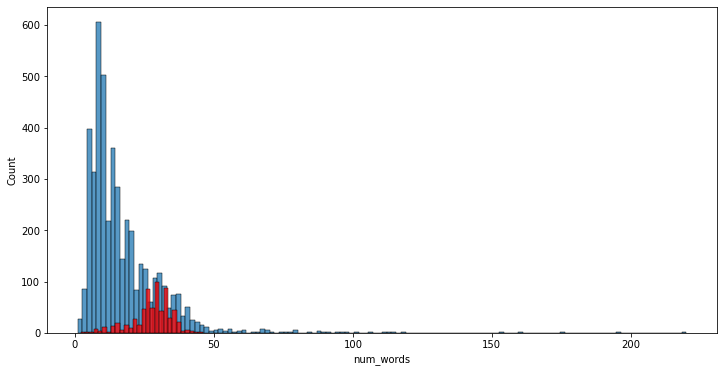

In [19]:
plt.figure(figsize=(12,6))
sns.histplot(df[df['target']==0]['num_words'])               # ham
sns.histplot(df[df['target']==1]['num_words'], color='red')  # spam

<AxesSubplot:xlabel='num_sents', ylabel='Count'>

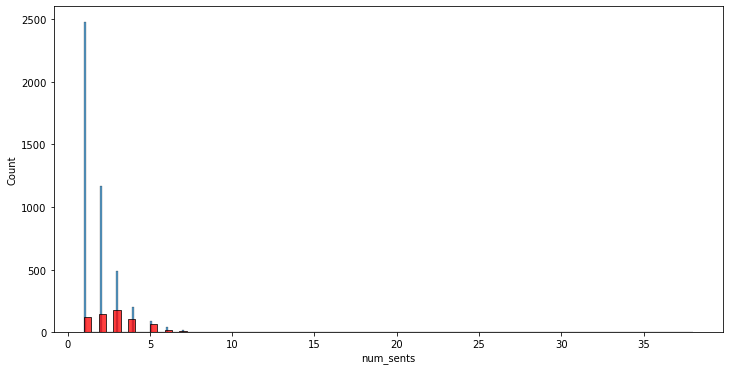

In [20]:
plt.figure(figsize=(12,6))
sns.histplot(df[df['target']==0]['num_sents'])               # ham
sns.histplot(df[df['target']==1]['num_sents'], color='red')  # spam

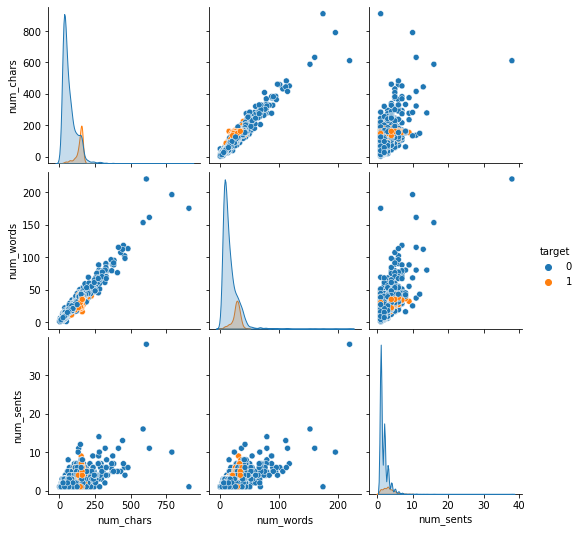

In [21]:
sns.pairplot(df, hue='target')

Observation : there are outliers in tha dataset.

In [23]:
# check the correlation between num_chars, num_words and num_sents
df.corr()

,target,num_chars,num_words,num_sents
target,1.000000,0.384717,0.262969,0.267602
num_chars,0.384717,1.000000,0.965784,0.626118
num_words,0.262969,0.965784,1.000000,0.680882
num_sents,0.267602,0.626118,0.680882,1.000000


<AxesSubplot:>

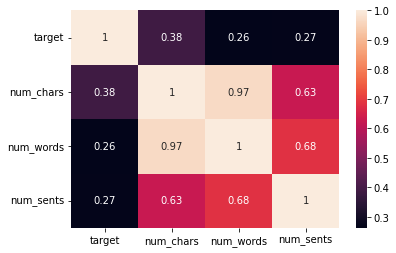

In [24]:
sns.heatmap(df.corr(), annot=True)

Observation : it is clear from the map that the columns num_chars, num_words and num_sents are highly correlated to each other. So all of them cannot be taken for building the model ( in order to avoid multicolinearity). If any one of these is to be used then num_chars will be the best choice because it has better correlation with the target column.

## Data Preprocessing
* lower case
* tokenization
* removing special charcters
* removing stop words and punctuations
* stemming

In [37]:
ps = PorterStemmer()

In [41]:
# defining a function to lower_case, tokenize and remove special characters from the text
def text_preprocess(text):
    # lower case text
    text = text.lower()   
    
    # tokenization
    text = nltk.word_tokenize(text)       
    y = []    
    
    # removing punctuations
    for i in text:                        
        if i.isalnum():
            y.append(i)
    text = y[:]
    y.clear()
    
    # removing stopwords
    for i in text:
        if i not in stopwords.words('english') and i not in string.punctuation:
            y.append(i)
            
    text = y[:]
    y.clear()
    for i in text:
        y.append(ps.stem(i))
        
    return " ".join(y)

In [43]:
df['transform_text'] = df['text'].apply(text_preprocess)

In [44]:
df.head()

,target,text,num_chars,num_words,num_sents,transform_text
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2,go jurong point crazi avail bugi n great world...
1,0,Ok lar... Joking wif u oni...,29,8,2,ok lar joke wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,free entri 2 wkli comp win fa cup final tkt 21...
3,0,U dun say so early hor... U c already then say...,49,13,1,u dun say earli hor u c alreadi say
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1,nah think goe usf live around though


In [57]:
wc = WordCloud(width=500, height=500, min_font_size=10, background_color='white')
spam_wc = wc.generate(df[df['target']==1]['transform_text'].str.cat(sep=' '))
ham_wc = wc.generate(df[df['target']==0]['transform_text'].str.cat(sep=' '))


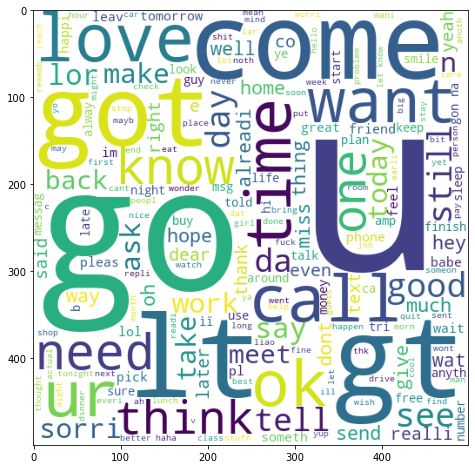

In [58]:
plt.figure(figsize=(12,8))
plt.imshow(spam_wc)

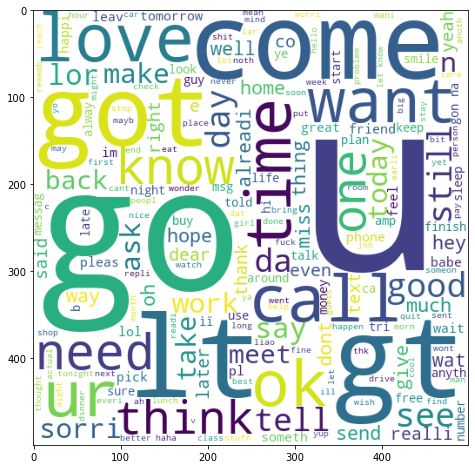

In [59]:
plt.figure(figsize=(12,8))
plt.imshow(ham_wc)

In [65]:
# finding most frequently used words in ham and spam
spam_corpus = []
for msg in df[df['target']==1]['transform_text'].tolist():
    for word in msg.split():
        spam_corpus.append(word)
        
print(" spam_corpus", len(spam_corpus))

ham_corpus = []
for msg in df[df['target']==0]['transform_text'].tolist():
    for word in msg.split():
        ham_corpus.append(word)
        
print(" ham_corpus", len(ham_corpus))

 spam_corpus 9939
 ham_corpus 35402


In [72]:
s1 = pd.DataFrame(Counter(spam_corpus).most_common(30))
h1 = pd.DataFrame(Counter(ham_corpus).most_common(30))

C:\Users\ATUL\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


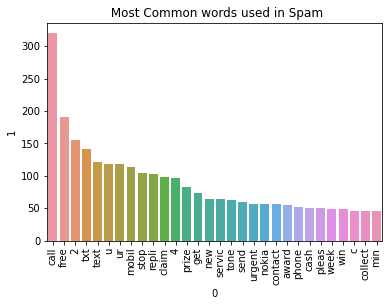

In [75]:
sns.barplot(s1[0], s1[1])
 
plt.xticks(rotation='vertical')
plt.title(" Most Common words used in Spam")
plt.show()

C:\Users\ATUL\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


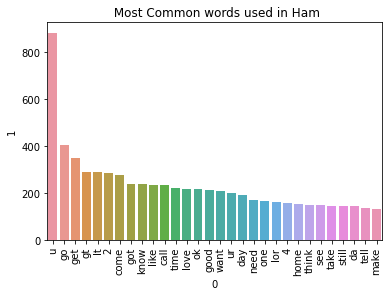

In [76]:
sns.barplot(h1[0], h1[1])
plt.xticks(rotation='vertical')
plt.title(" Most Common words used in Ham")
plt.show()

## Model Building

In [114]:
#1. vectorizing the input text - (BOW or TFIDF or Word2Vec)
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
#cv = CountVectorizer()
tf = TfidfVectorizer()
#x = cv.fit_transform(df['transform_text']).toarray()
x = tf.fit_transform(df['transform_text']).toarray()
x.shape

(5169, 3000)

In [93]:
y = df['target'].values

In [94]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [95]:
mnb = MultinomialNB()
gnb = GaussianNB()
bnb = BernoulliNB()


In [96]:
# GausianNB
gnb.fit(x_train, y_train)
y_pred1 = gnb.predict(x_test)
print("accuracy : ",accuracy_score(y_test, y_pred1)*100)
print("precision :", precision_score(y_test, y_pred1)*100)
print("Confusion matrix : \n", confusion_matrix(y_test, y_pred1))

accuracy :  86.36363636363636
precision : 50.84033613445378
Confusion matrix : 
 [[772 117]
 [ 24 121]]


In [97]:
# MultinomialNM
mnb.fit(x_train, y_train)
y_pred2 = mnb.predict(x_test)
print("accuracy : ",accuracy_score(y_test, y_pred2)*100)
print("precision :", precision_score(y_test, y_pred2)*100)
print("Confusion matrix : \n", confusion_matrix(y_test, y_pred2))

accuracy :  96.13152804642166
precision : 99.06542056074767
Confusion matrix : 
 [[888   1]
 [ 39 106]]


In [98]:
# BinomialNB
bnb.fit(x_train, y_train)
y_pred3 = bnb.predict(x_test)
print("accuracy : ",accuracy_score(y_test, y_pred3)*100)
print("precision :", precision_score(y_test, y_pred3)*100)
print("Confusion matrix : \n", confusion_matrix(y_test, y_pred3))

accuracy :  96.61508704061895
precision : 96.61016949152543
Confusion matrix : 
 [[885   4]
 [ 31 114]]


Conclusion : from the above results it is clear that MultinomialNB is performing better than other models when used with TfidfVectorizer. 
#### tfidf -> MultinomialNB

In [102]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

In [104]:
lrc = LogisticRegression(solver='liblinear', penalty='l1')
svc = SVC(kernel='sigmoid', gamma=1.0)
mnb = MultinomialNB()
dtc = DecisionTreeClassifier(max_depth=5)
rfc = RandomForestClassifier(n_estimators=50, random_state=2)
knc = KNeighborsClassifier()
abc = AdaBoostClassifier(n_estimators=50, random_state=2)
bc = BaggingClassifier(n_estimators=50, random_state=2)
etc = ExtraTreesClassifier(n_estimators=50, random_state=2)
gbc = GradientBoostingClassifier(n_estimators=50, random_state=2)
xgb = XGBClassifier(n_estimators=50, random_state=2)

In [106]:
clfs = {
    'LR': lrc,
    'SVM': svc,
    'MNB': mnb,
    'DTC': dtc,
    'RFC': rfc,
    'KNC': knc,
    'ABC': abc,
    'BC': bc,
    'ETC': etc,
    'GBC': gbc,
    'XGB': xgb
}

In [107]:
def train_classifier(clf, x_train, y_train, x_test, y_test):
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    acc = accuracy_score(y_test, y_pred)
    pre = precision_score(y_test, y_pred)
    
    return acc,pre

In [108]:
acc_score = []
pre_score = []
for name,clf in clfs.items():
    acc, pre = train_classifier(clf, x_train, y_train, x_test, y_test)
    acc_score.append(acc)
    pre_score.append(pre)

In [109]:
performance_df = pd.DataFrame({'Algo':clfs.keys(), 'Accuracy': acc_score, 'Precision': pre_score})
performance_df

,Algo,Accuracy,Precision
0,LR,0.943907,0.865546
1,SVM,0.972921,0.946565
2,MNB,0.961315,0.990654
3,DTC,0.935203,0.814516
4,RFC,0.968085,0.991228
5,KNC,0.896518,1.000000
6,ABC,0.947776,0.842105
7,BC,0.961315,0.877698
8,ETC,0.973888,0.991667
9,GBC,0.950677,0.951923


In [111]:
performance_df1 = pd.melt(performance_df, id_vars='Algo')
performance_df1

,Algo,variable,value
0,LR,Accuracy,0.943907
1,SVM,Accuracy,0.972921
2,MNB,Accuracy,0.961315
3,DTC,Accuracy,0.935203
4,RFC,Accuracy,0.968085
5,KNC,Accuracy,0.896518
6,ABC,Accuracy,0.947776
7,BC,Accuracy,0.961315
8,ETC,Accuracy,0.973888
9,GBC,Accuracy,0.950677


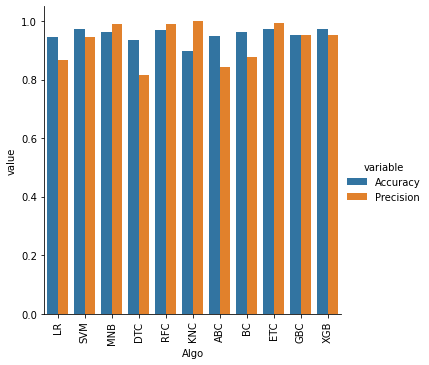

In [113]:
sns.catplot(x='Algo', y='value', hue='variable', data=performance_df1, kind='bar')
plt.xticks(rotation='vertical')
plt.show()

## Model Improvement

In [115]:
# changed the max_features=3000 in Tfidf_vectorizer
tf = TfidfVectorizer(max_features=3000)
x = tf.fit_transform(df['transform_text']).toarray()
x.shape

(5169, 3000)

In [116]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [117]:
acc_score_tf3000 = []
pre_score_tf3000 = []
for name,clf in clfs.items():
    acc, pre = train_classifier(clf, x_train, y_train, x_test, y_test)
    acc_score_tf3000.append(acc)
    pre_score_tf3000.append(pre)

In [118]:
performance_df['Acc_maxft_3000'] = acc_score_tf3000
performance_df['Pre_maxft_3000'] = pre_score_tf3000
performance_df

,Algo,Accuracy,Precision,Acc_maxft_3000,Pre_maxft_3000
0,LR,0.943907,0.865546,0.946809,0.868852
1,SVM,0.972921,0.946565,0.976789,0.954887
2,MNB,0.961315,0.990654,0.972921,0.991597
3,DTC,0.935203,0.814516,0.933269,0.827586
4,RFC,0.968085,0.991228,0.973888,0.983607
5,KNC,0.896518,1.000000,0.910058,1.000000
6,ABC,0.947776,0.842105,0.950677,0.867188
7,BC,0.961315,0.877698,0.961315,0.883212
8,ETC,0.973888,0.991667,0.978723,0.992000
9,GBC,0.950677,0.951923,0.946809,0.968750


In [119]:
performance_df2 = pd.melt(performance_df, id_vars='Algo')
performance_df2

,Algo,variable,value
0,LR,Accuracy,0.943907
1,SVM,Accuracy,0.972921
2,MNB,Accuracy,0.961315
3,DTC,Accuracy,0.935203
4,RFC,Accuracy,0.968085
5,KNC,Accuracy,0.896518
6,ABC,Accuracy,0.947776
7,BC,Accuracy,0.961315
8,ETC,Accuracy,0.973888
9,GBC,Accuracy,0.950677


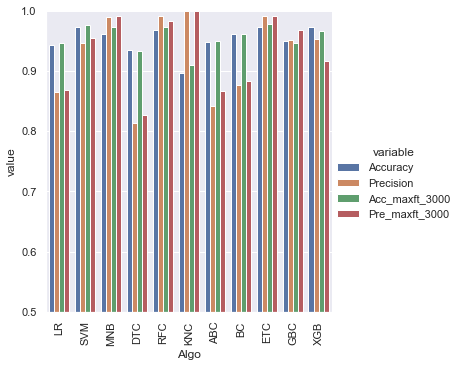

In [125]:
sns.catplot(x='Algo', y='value', hue='variable', data=performance_df2, kind='bar')
plt.xticks(rotation='vertical')
plt.ylim(0.5,1.0)
sns.set(rc = {'figure.figsize':(15,8)})
plt.show()

### Conclusion : 
##### KNC has precision 1 and its accuracy is 91%
#####                        MNB has precision 99.15% and its accuracy is 97.29%
#####                        ETC has precision 99.2% and its accuracy is 97.87%
##### Since it is a classification task of an imbalanced dataset, precision is very important metrics along with accuracy.
##### KNC has good precision but its accuracy is not good, MNB has a good combination of accuracy and precision but 
##### ETC has both precision and accuracy more than MNB.
##### Thus ETC is selected as the final model.

In [127]:
import pickle
pickle.dump(tf, open('vectorizer.pkl', 'wb'))
pickle.dump(etc, open('model.pkl', 'wb'))